In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("training_summary.csv")
df.head()

,filename,date,sport_type,total_distance_km,duration_min,avg_pace_min_per_km,avg_heart_rate_bpm,avg_cadence_spm
0,466131603708477441.tcx,2025-01-10,Running,10.14,64.9,6.61,153,159.0
1,465993076817559567.tcx,2025-01-04,Running,12.10,77.9,6.54,157,161.0
2,468241750159294476.tcx,2025-04-11,Running,3.22,28.6,8.14,143,152.0
3,464901549538181129.tcx,2024-11-18,Running,5.01,40.0,8.24,133,155.0
4,462512906152476676.tcx,2024-08-07,Running,10.11,76.3,9.05,161,144.0


In [2]:
df.info()
df.describe()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             334 non-null    object 
 1   date                 334 non-null    object 
 2   sport_type           334 non-null    object 
 3   total_distance_km    334 non-null    float64
 4   duration_min         334 non-null    float64
 5   avg_pace_min_per_km  309 non-null    float64
 6   avg_heart_rate_bpm   334 non-null    int64  
 7   avg_cadence_spm      309 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 21.0+ KB


filename                0
date                    0
sport_type              0
total_distance_km       0
duration_min            0
avg_pace_min_per_km    25
avg_heart_rate_bpm      0
avg_cadence_spm        25
dtype: int64

In [3]:
df['date'] = pd.to_datetime(df['date'])

<AxesSubplot: >

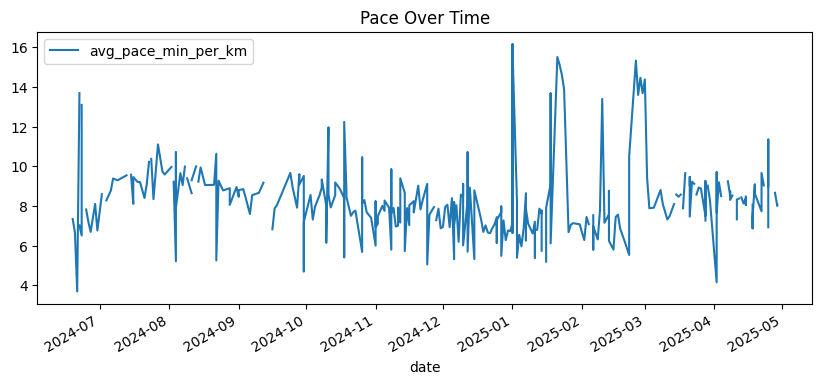

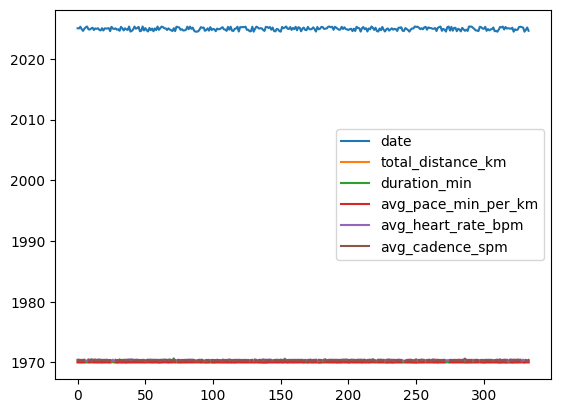

In [4]:
# treands over time
df.sort_values('date').plot(x='date', y='avg_pace_min_per_km', title='Pace Over Time', figsize=(10, 4))
df.plot()

<AxesSubplot: >

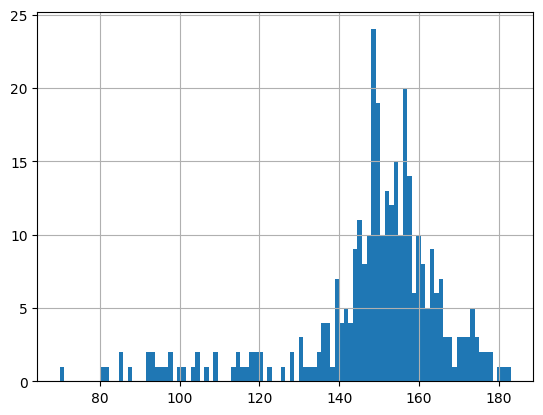

In [5]:
# distribution of HR
df['avg_heart_rate_bpm'].hist(bins=100)

<AxesSubplot: title={'center': 'Weekly Distance'}, xlabel='week'>

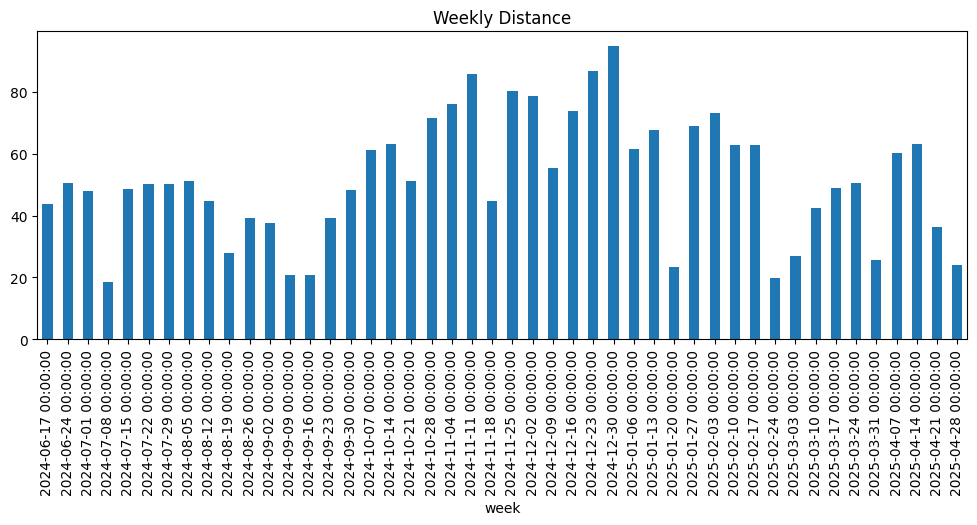

In [6]:
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
df.groupby('week')['total_distance_km'].sum().plot(kind='bar', figsize=(12, 4), title="Weekly Distance")

In [7]:
# Filter out invalid cadence/pace values
filtered_df = df[(df['avg_pace_min_per_km'] > 3) & (df['avg_pace_min_per_km'] < 10)]

# Drop rows where cadence or pace is missing
filtered_df = filtered_df.dropna(subset=['avg_pace_min_per_km', 'avg_cadence_spm'])

# Display the filtered dataframe
filtered_df.head()

,filename,date,sport_type,total_distance_km,duration_min,avg_pace_min_per_km,avg_heart_rate_bpm,avg_cadence_spm,week
0,466131603708477441.tcx,2025-01-10,Running,10.14,64.9,6.61,153,159.0,2025-01-06
1,465993076817559567.tcx,2025-01-04,Running,12.10,77.9,6.54,157,161.0,2024-12-30
2,468241750159294476.tcx,2025-04-11,Running,3.22,28.6,8.14,143,152.0,2025-04-07
3,464901549538181129.tcx,2024-11-18,Running,5.01,40.0,8.24,133,155.0,2024-11-18
4,462512906152476676.tcx,2024-08-07,Running,10.11,76.3,9.05,161,144.0,2024-08-05


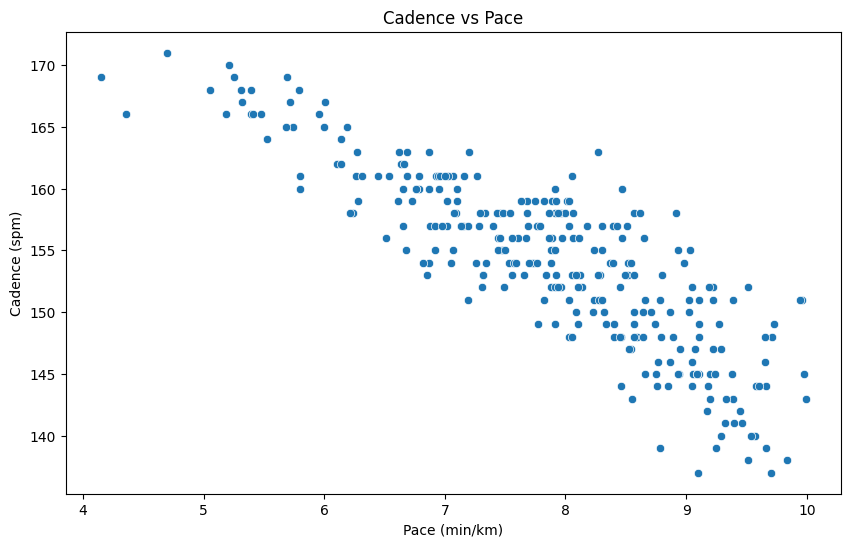

In [61]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='avg_pace_min_per_km', y='avg_cadence_spm')
plt.title('Cadence vs Pace')
plt.xlabel('Pace (min/km)')
plt.ylabel('Cadence (spm)')
plt.show()

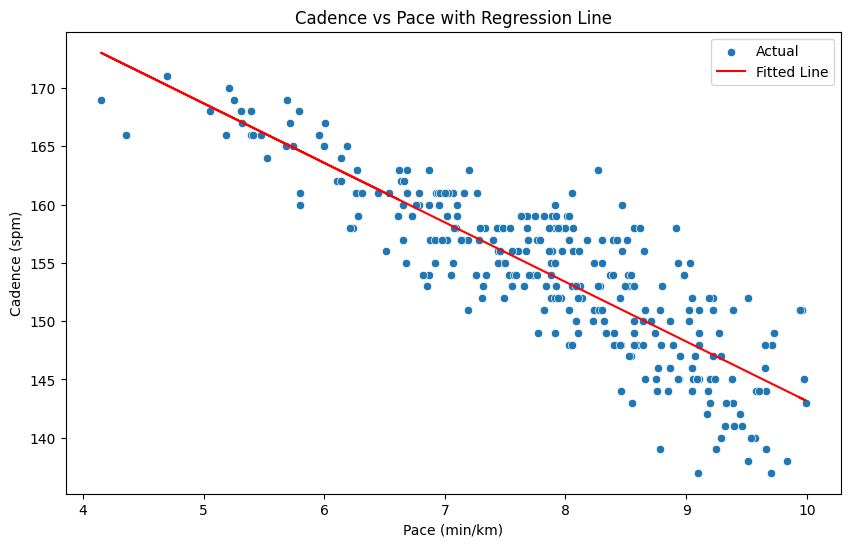

In [62]:
from sklearn.linear_model import LinearRegression

# Prepare the data for regression
X = filtered_df[['avg_pace_min_per_km']].values  # Predictor: Pace
y = filtered_df['avg_cadence_spm'].values  # Response: Cadence

# Create and train the regression model
model = LinearRegression()
model.fit(X, y)

# Predict cadence based on pace values
filtered_df['predicted_cadence'] = model.predict(X)

# Plot the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='avg_pace_min_per_km', y='avg_cadence_spm', label='Actual')
plt.plot(filtered_df['avg_pace_min_per_km'], filtered_df['predicted_cadence'], color='red', label='Fitted Line')
plt.title('Cadence vs Pace with Regression Line')
plt.xlabel('Pace (min/km)')
plt.ylabel('Cadence (spm)')
plt.legend()
plt.show()

In [63]:
optimal_pace = 5.14  # Pace in min/km
optimal_cadence = model.predict([[optimal_pace]])[0]
print(f"The optimal cadence for {optimal_pace} min/km is approximately {optimal_cadence:.0f} steps per minute.")

The optimal cadence for 5.14 min/km is approximately 168 steps per minute.


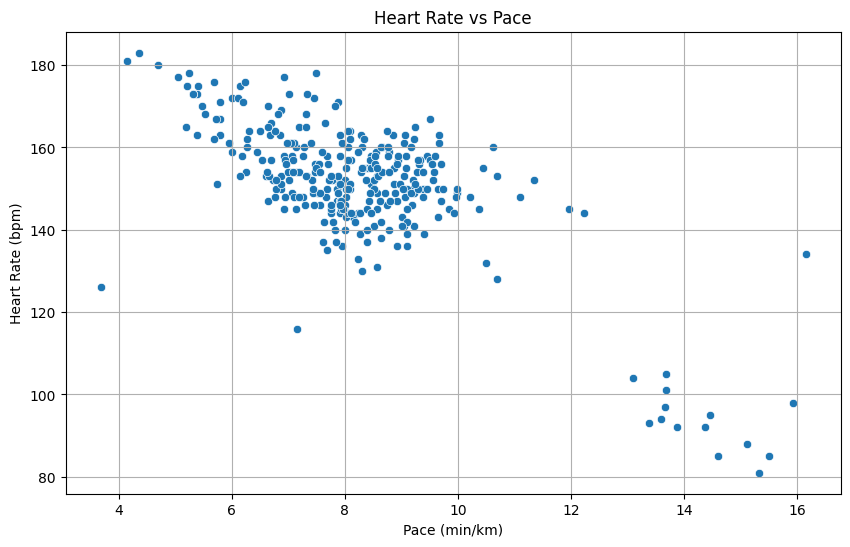

In [64]:
# HR vs pace 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="avg_pace_min_per_km", y="avg_heart_rate_bpm")
plt.title("Heart Rate vs Pace")
plt.xlabel("Pace (min/km)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.show()

In [65]:
hr = df["avg_heart_rate_bpm"].mean()
print(hr)

148.28443113772454


In [66]:
# Manual thereshold 
def classify_run(hr):
    if hr < 135:
        return "easy"
    elif  155 < hr < 175:
        return "tempo"
    else:
        return "repetition"

df["run_type"] = df["avg_heart_rate_bpm"].apply(classify_run)

In [67]:
# Get average pace per run type
df.groupby("run_type")["avg_pace_min_per_km"].describe()

,count,mean,std,min,25%,50%,75%,max
run_type,,,,,,,,
easy,22.0,12.435000,3.334607,3.69,10.5425,13.675,14.5725,16.15
repetition,181.0,8.138840,1.268814,4.15,7.4800,8.060,8.9800,12.23
tempo,106.0,7.610094,1.280819,5.19,6.6825,7.565,8.6550,10.63


In [68]:
for run_type in df["run_type"].unique():
    mean_pace = df[df["run_type"] == run_type]["avg_pace_min_per_km"].mean()
    print(f"{run_type.title()} run: optimal average pace ≈ {mean_pace:.2f} min/km")

Repetition run: optimal average pace ≈ 8.14 min/km
Tempo run: optimal average pace ≈ 7.61 min/km
Easy run: optimal average pace ≈ 12.44 min/km
